### FINAL PROJECT - JEN, THEA, SARATH, FRANCIS 
### --- DATING ANALYSIS ---
### PREDICT WHETHER DATERS WANT TO MEET AGAIN

In [12]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pltt
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
scorer = make_scorer(fbeta_score, beta=1.5)

# Some warnings tend to pop up during grid search
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
data = pd.read_csv('Data/Speed_Dating_Data.csv', encoding='latin-1', engine="python")

print(data.shape[0], 'observations and', data.shape[1], 'features')

8378 observations and 195 features


In [14]:
# What kind of data are we dealing with?
data.dtypes.value_counts()

float64    174
int64       13
object       8
dtype: int64

In [15]:
# Men (1) and women (0)
data.groupby('iid').mean().gender.value_counts()

1.0    277
0.0    274
Name: gender, dtype: int64

In [16]:
# What percentage of pairs resulted in a match?
data['match'].value_counts(normalize=True)

0    0.835283
1    0.164717
Name: match, dtype: float64

In [17]:
data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [18]:
# Waves 6-11 rated importance, others allocated 100 points
points = (data.wave != 6 ) &\
    (data.wave != 7 ) &\
    (data.wave != 8 ) &\
    (data.wave != 9 ) &\
    (data.wave != 10 ) &\
    (data.wave != 11 )

data = data[points]

In [19]:
info = ['attr_o','sinc_o','intel_o','fun_o','amb_o','shar_o','like_o','race','pid','dec_o',
        'gender','age', 'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','go_out',
        'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga','match']
df = data[info]


In [20]:
df.fillna(0)
df = df[np.isfinite(df).all(1)]

In [21]:
# Just a sample of how much missing data we have.
df.isnull().sum().sort_values(ascending=False)[:10]

match       0
pf_o_sha    0
pf_o_fun    0
pf_o_int    0
pf_o_sin    0
pf_o_att    0
age         0
gender      0
dec_o       0
pid         0
dtype: int64

In [22]:
X = df[['attr_o','sinc_o','intel_o','fun_o','amb_o','shar_o','race','dec_o','gender','age', 'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga']]
y = df['like_o'].values.reshape(-1,1)
print(X.shape, y.shape)

(4639, 34) (4639, 1)


In [23]:
print(X)

      attr_o  sinc_o  intel_o  fun_o  amb_o  shar_o  race  dec_o  gender  \
0        6.0     8.0      8.0    8.0    8.0     6.0   4.0      0       0   
1        7.0     8.0     10.0    7.0    7.0     5.0   4.0      0       0   
2       10.0    10.0     10.0   10.0   10.0    10.0   4.0      1       0   
3        7.0     8.0      9.0    8.0    9.0     8.0   4.0      1       0   
4        8.0     7.0      9.0    6.0    9.0     7.0   4.0      1       0   
5        7.0     7.0      8.0    8.0    7.0     7.0   4.0      1       0   
6        3.0     6.0      7.0    5.0    8.0     7.0   4.0      0       0   
7        6.0     7.0      5.0    6.0    8.0     6.0   4.0      0       0   
8        7.0     7.0      8.0    8.0    8.0     9.0   4.0      1       0   
9        6.0     6.0      6.0    6.0    6.0     6.0   4.0      0       0   
10       8.0     7.0      6.0    9.0    7.0     4.0   2.0      0       0   
11       7.0     6.0     10.0    6.0    6.0     5.0   2.0      0       0   
12      10.0

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X, y)
rf.score(X, y)


0.9514779465540049

In [25]:
importances = rf.feature_importances_
importances

array([0.15123724, 0.03226871, 0.02466175, 0.31839436, 0.01522344,
       0.16332692, 0.00611486, 0.02820897, 0.00257848, 0.01338452,
       0.01471777, 0.01464727, 0.01614182, 0.01215188, 0.01270987,
       0.01296185, 0.00673442, 0.0091534 , 0.00975707, 0.00983061,
       0.0086204 , 0.00751171, 0.00738648, 0.01033327, 0.0111024 ,
       0.01043718, 0.00946623, 0.00997433, 0.00800023, 0.00703792,
       0.0079798 , 0.00820863, 0.00942428, 0.01031196])

In [26]:
sorted(zip(rf.feature_importances_, df.columns), reverse=True)

[(0.3183943567401887, 'fun_o'),
 (0.16332692318560973, 'shar_o'),
 (0.15123724080034134, 'attr_o'),
 (0.032268709148599584, 'sinc_o'),
 (0.0282089691618708, 'race'),
 (0.024661748421618092, 'intel_o'),
 (0.016141815982781367, 'pf_o_att'),
 (0.015223438427282729, 'amb_o'),
 (0.014717771782531343, 'gender'),
 (0.014647270000086915, 'age'),
 (0.013384516432992955, 'dec_o'),
 (0.012961846175897011, 'pf_o_fun'),
 (0.012709873752756675, 'pf_o_int'),
 (0.012151880288951755, 'pf_o_sin'),
 (0.011102397828780666, 'art'),
 (0.010437179100371225, 'hiking'),
 (0.010333274151887966, 'museums'),
 (0.010311962901723997, 'music'),
 (0.009974327218871756, 'clubbing'),
 (0.009830607808695725, 'sports'),
 (0.009757071900725087, 'go_out'),
 (0.009466226351372923, 'gaming'),
 (0.00942427517247108, 'concerts'),
 (0.009153399236798263, 'pf_o_sha'),
 (0.008620404164475019, 'tvsports'),
 (0.00820863310396622, 'movies'),
 (0.008000229274359286, 'reading'),
 (0.007979796659641198, 'theater'),
 (0.0075117052993010

In [32]:
def fix_numeric(col, data=data, median=False):
    try:
        data[col] = data[col].str.replace(',', '')
    except:
        print('Column is not a string!')
    
    data[col] = data[col].astype(float)
 
    
    

    data[col] = data[col].fillna(0)
    

    return data



for i in 'zipcode mn_sat tuition income'.split():
    data = fix_numeric(i)

Column is not a string!
Column is not a string!
Column is not a string!
Column is not a string!


In [33]:
data.dtypes.value_counts()

float64    178
int64       13
object       4
dtype: int64

In [36]:
data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [37]:
data.fillna(0).head()


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,0.0,4,...,5.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0,1,1,1,10,7,0.0,3,...,5.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,0,1,1,1,10,7,0.0,10,...,5.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0,1,1,1,10,7,0.0,5,...,5.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0,1,1,1,10,7,0.0,7,...,5.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#Benchmark, dummy predictor
from sklearn.dummy import DummyClassifier

data_benchmark = pd.get_dummies(data)
data_benchmark.fillna(data_benchmark.median(), inplace=True)

xbench = data_benchmark.drop('match', axis=1)
ybench = data_benchmark['match']

dum = DummyClassifier(strategy='constant', constant=1)

cvs = cross_val_score(dum, xbench, ybench, scoring=scorer, cv=5)

benchmark_score = cvs.mean()

print('Naive Benchmark:', benchmark_score)

Naive Benchmark: 0.395128896198807


In [39]:
def get_partner_data(pid, col):
    '''Looks up the person's partner and adds their data
    as new features. If the partner ID doesn't exist,
    returns a -1.'''
    try:
        partner = data[data['iid'] == pid].head(1)[col].iloc[0]
        if partner:
            return partner
        else:
            return -1
    except:
        return -1

In [40]:

# Age
data['age'].fillna(data['age'].median(), inplace=True)
data['age_o'].fillna(data['age_o'].median(), inplace=True)
data['age_difference'] = data['age'] - data['age_o']

# Attractiveness
data['partner_attractiveness'] = data['pid'].apply(get_partner_data, col='attr3_1')
data['attr_expectations'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                     data['partner_attractiveness']
data['partner_attractiveness_2'] = data['pid'].apply(get_partner_data, col='attr5_1')
data['attr_expectations_2'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                       data['partner_attractiveness_2']

# Intelligence
data['partner_intelligence'] = data['pid'].apply(get_partner_data, col='intel3_1')
data['intel_expectations'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                     data['partner_intelligence']
data['partner_intelligence_2'] = data['pid'].apply(get_partner_data, col='intel5_1')
data['intel_expectations_2'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                       data['partner_intelligence_2']

# Fun
data['partner_fun'] = data['pid'].apply(get_partner_data, col='fun3_1')
data['fun_expectations'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                     data['partner_fun']
data['partner_fun_2'] = data['pid'].apply(get_partner_data, col='fun5_1')
data['fun_expectations_2'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                       data['partner_fun_2']

# Ambitious
data['partner_ambition'] = data['pid'].apply(get_partner_data, col='amb3_1')
data['amb_expectations'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                     data['partner_ambition']
data['partner_ambition_2'] = data['pid'].apply(get_partner_data, col='amb5_1')
data['amb_expectations_2'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                       data['partner_ambition_2']

# Sincerity
data['partner_sincerity'] = data['pid'].apply(get_partner_data, col='sinc3_1')
data['sinc_expectations'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                     data['partner_sincerity']
data['partner_sincerity_2'] = data['pid'].apply(get_partner_data, col='sinc5_1')
data['sinc_expectations_2'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                       data['partner_sincerity_2']

In [41]:
#Measuring Expectations
# Measuring expectations one more way

data['attr_above_avg'] = np.where(data['partner_attractiveness'] > data['partner_attractiveness'].mean(),
                                  1, 0)
data['attr_imp_above_avg']= np.where(data['attr1_1'] > data['attr1_1'].mean(),
                                     1, 0)
data['attr_match'] = np.where(data['attr_above_avg'] >= data['attr_imp_above_avg'],
                             1, 0)

data['sinc_above_avg'] = np.where(data['partner_sincerity'] > data['partner_sincerity'].mean(),
                                  1, 0)
data['sinc_imp_above_avg']= np.where(data['sinc1_1'] > data['sinc1_1'].mean(),
                                     1, 0)
data['sinc_match'] = np.where(data['sinc_above_avg'] >= data['sinc_imp_above_avg'],
                             1, 0)

data['int_above_avg'] = np.where(data['partner_intelligence'] > data['partner_intelligence'].mean(),
                                  1, 0)
data['int_imp_above_avg']= np.where(data['intel1_1'] > data['intel1_1'].mean(),
                                     1, 0)
data['int_match'] = np.where(data['int_above_avg'] >= data['int_imp_above_avg'],
                             1, 0)

data['fun_above_avg'] = np.where(data['partner_fun'] > data['partner_fun'].mean(),
                                  1, 0)
data['fun_imp_above_avg']= np.where(data['fun1_1'] > data['fun1_1'].mean(),
                                     1, 0)
data['fun_match'] = np.where(data['fun_above_avg'] >= data['fun_imp_above_avg'],
                             1, 0)

In [42]:
#Hobbies
hobbies = ['go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga']

for i in hobbies:
    data['partner_' + i] = data['pid'].apply(get_partner_data, col=i)
    data[i + '_in_common'] = np.where((data[i] > 7) & (data['partner_' + i] > 7), 1, 0)
    del data['partner_' + i]

In [49]:
df1=data.dropna(axis=1)

In [50]:
#Remove dummies when one person has 1

#****Remove # to delete data after running first time
counts =\
by_iid = df1.groupby('iid').mean().sum(axis=0).sort_values()


In [51]:
deleted = []

for i in counts[counts < 2].index:
    if 'dummy_' in i:
        deleted.append(i)
       # del data[i]

# Fix anything that got counted twice
for i in df.columns:
    if 'dummy_' in i:
        df1[i] = np.where(df1[i] >= 1, 1, 0)

In [52]:
# Nearly 500 features removed. Not bad!
print('Deleted:', len(deleted))
print('Data shape:', df1.shape)

Deleted: 0
Data shape: (5772, 50)


In [53]:
print('Data shape:', df1.shape)

Data shape: (5772, 50)


In [54]:
# Checkpoint
df1.to_csv('Speed Dating Data RF.csv')

Text(0.5, 1.0, 'Importance of attractiveness vs. ambition in men and women')

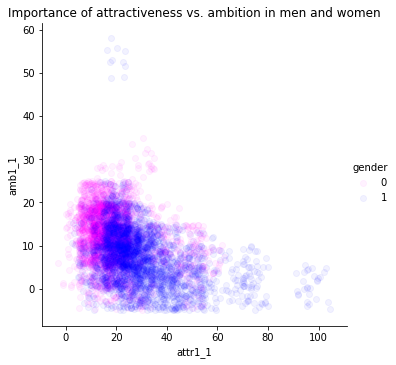

In [55]:
###Visualizations
sns.lmplot("attr1_1", "amb1_1",
           data=data, hue='gender', fit_reg=False,
           x_jitter=5, y_jitter=5,
           palette=['magenta', 'blue'],
           scatter_kws={'alpha':.05})
plt.title('Importance of attractiveness vs. ambition in men and women')

Text(0.5, 0, 'Age')

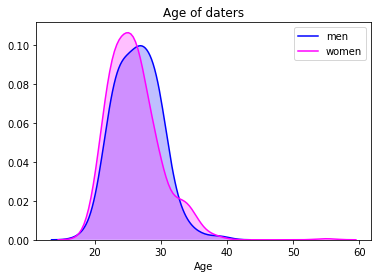

In [56]:
sns.kdeplot(data[data.gender == 1].age,
            bw=1.5, shade=True, color='blue', label='men')
sns.kdeplot(data[data.gender == 0].age,
            bw=1.5, shade=True, color='magenta', label='women')
plt.title('Age of daters')
plt.xlabel('Age')

In [57]:
#Gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV

x = df1.drop('match', axis=1)
y = df1['match']

# Fixing a csv import bug
for i in x.columns:
    if 'Unnamed' in i:
        del x[i]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

xtrain.shape

(4617, 49)

In [58]:
#Using K-Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,9,2)}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform') 

Mean score: 0.2529229995778443
Std Dev:    0.04953142867950721


In [59]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.0018603319977103607
Std Dev:    0.0032221895389804535


In [60]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'],
         'C': [.1, 1, 10, 100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Mean score: 1.0
Std Dev:    0.0


In [61]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
params = {'max_depth': list(np.arange(2,13)) + [None],
         'min_samples_leaf': [1,2,3,4,5,6,7,10]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Mean score: 1.0
Std Dev:    0.0


In [62]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
params = {'max_depth': list(np.arange(3,10)) + [None],
         'min_samples_leaf': [1,2,3],
         'n_estimators': [10,100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Mean score: 1.0
Std Dev:    0.0


In [63]:
# Some Stackoverflow code to fix duplicate column names AGAIN
cols = pd.Series(df1.columns)

for dup in df1.columns.get_duplicates():
    cols[df1.columns.get_loc(dup)] =\
    [dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(df1.columns.get_loc(dup).sum())]

df1.columns = cols

df1.shape

(5772, 50)

In [64]:
from xgboost import XGBClassifier


clf = XGBClassifier()
params = {'max_depth': list(np.arange(3,10)) + [100],
         'base_score': np.arange(.42,.52,.01),
         'n_estimators': [100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.42, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
       verbosity=1) 

Mean score: 1.0
Std Dev:    0.0


In [65]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {'max_depth': [9],
         'base_score': np.arange(.40,.45,.007),
         'n_estimators': [100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
       verbosity=1) 

Mean score: 1.0
Std Dev:    0.0


In [66]:
#Dimensionality Reduction & Grid Search

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV, train_test_split

pl = Pipeline([
    ('reduce_dim', SelectPercentile()),
    ('classify', XGBClassifier())
])

# Recall that I've run this notebook multiple times
# and did a MUCH more exhaustive search previously.
PERC_OPTIONS = np.arange(44,58,2) # It consistently settles on a value around 50-55
EST_OPTIONS = [400] # Best setting I found; we'll only use this to save time
DEPTH_OPTIONS = [6,7,8,9]

param_grid = [
    {
        'reduce_dim__percentile': PERC_OPTIONS,
        'classify__n_estimators': EST_OPTIONS,
        'classify__max_depth': DEPTH_OPTIONS,
    },
]

grid =\
GridSearchCV(pl, cv=3, n_jobs=1, param_grid=param_grid, scoring=scorer)\
.fit(xtrain, ytrain)

model = grid.best_estimator_

In [67]:
model.named_steps['classify']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
       verbosity=1)

In [68]:
model.named_steps['reduce_dim']

SelectPercentile(percentile=44,
         score_func=<function f_classif at 0x1c23b48d90>)

In [69]:
cv = cross_val_score(model, xtrain, ytrain, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 1.0
Std Dev:    0.0


In [70]:
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

class MatchMakingClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator, threshold=50):
        self.estimator = estimator
        self.threshold = threshold

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def predict(self, X):
        pred = self.estimator.predict_proba(X)[:,1]
        pred = np.where(pred > np.percentile(pred, self.threshold), 1, 0)
        return pred

In [71]:
clf = MatchMakingClassifier(model)
params = {'threshold': [48,48.5,49]}
grid = GridSearchCV(clf, param_grid=params, cv=5, scoring=scorer).fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=5, scoring=scorer)

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

MatchMakingClassifier(estimator=Pipeline(memory=None,
     steps=[('reduce_dim', SelectPercentile(percentile=44,
         score_func=<function f_classif at 0x1c23b48d90>)), ('classify', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       learning_rate=0.1, max_delta_s...a=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
       verbosity=1))]),
           threshold=49) 

Mean score: 0.6116071024853217
Std Dev:    0.0014661433996827427


In [72]:
pred = clf.predict(xtest)

fbeta_score(ytest, pred, beta=1.5)

0.6244267439053826

In [131]:
from sklearn.metrics import confusion_matrix
conf= confusion_matrix(ytest, pred)
conf

array([[567, 389],
       [  0, 199]])

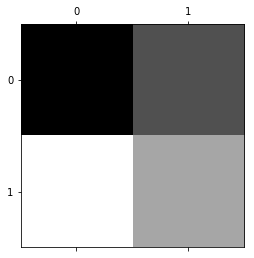

In [128]:
import matplotlib.pyplot as plt

plt.matshow(conf, cmap='binary', interpolation='None')
plt.show()

In [ ]:
#Sensitivity Analysis

In [73]:
from random import choice

def sensitivity_analysis(x=x, clf=clf, cols=10, print_scrambled=False):
    '''
    Originally I tried shuffling and scrambling the
    data. This takes a LONG time, so I eventually
    settled on simply randoming it.
    '''
    cv_scores = []
    
    # Average over 5 times
    for i in range(5):
        x_sens = x.copy()
        scrambled = []
        while len(scrambled) < cols:
            col_to_scramble = choice(x_sens.columns)
            scrambled.append(col_to_scramble)
            x_sens[col_to_scramble] = np.random.randn(len(x_sens))
        if print_scrambled:
            print('Scrambed:', scrambled)
        cv_scores.append(cross_val_score(clf, x_sens, y, cv=4, scoring=scorer).mean())
        
    print('Average cross val score ({} columns scrambled):'.format(cols), np.mean(cv_scores))

In [74]:
sensitivity_analysis(cols=10)

Average cross val score (10 columns scrambled): 0.6135579783440301


In [75]:
sensitivity_analysis(cols=20)

Average cross val score (20 columns scrambled): 0.5584882450348972


In [76]:
sensitivity_analysis(cols=50)

Average cross val score (50 columns scrambled): 0.32566099637049384


In [77]:
sensitivity_analysis(cols=75)

Average cross val score (75 columns scrambled): 0.5537454308262616


In [78]:
sensitivity_analysis(cols=100)

Average cross val score (100 columns scrambled): 0.32019251882564165


In [79]:
sensitivity_analysis(cols=200)

Average cross val score (200 columns scrambled): 0.37179382854781


In [80]:
sensitivity_analysis(cols=400)

Average cross val score (400 columns scrambled): 0.3184245876441792


In [81]:
#Cross Validation
cv = cross_val_score(clf, x, y, cv=4, scoring=scorer)

print('Mean f-beta: {0:.4f} (Std dev: {1:.4f})'.format(cv.mean(),  cv.std()))

Mean f-beta: 0.6146 (Std dev: 0.0015)


In [82]:
(cv.mean() - benchmark_score)/benchmark_score

0.5553541943866442

In [89]:
df1.fillna(0)
df1 = df1[np.isfinite(df1).all(1)]
#df1.to_csv('RF.csv')

In [95]:
np.where(df1.values >= np.finfo(np.float64).max)

(array([], dtype=int64), array([], dtype=int64))

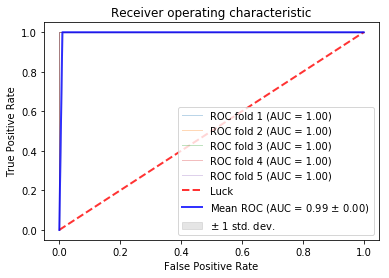

In [96]:
# Code from the sklearn documentation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x.values, y.values):
    probas_ = model.fit(x.iloc[train], y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

AttributeError: 'MatchMakingClassifier' object has no attribute 'get_fscore'

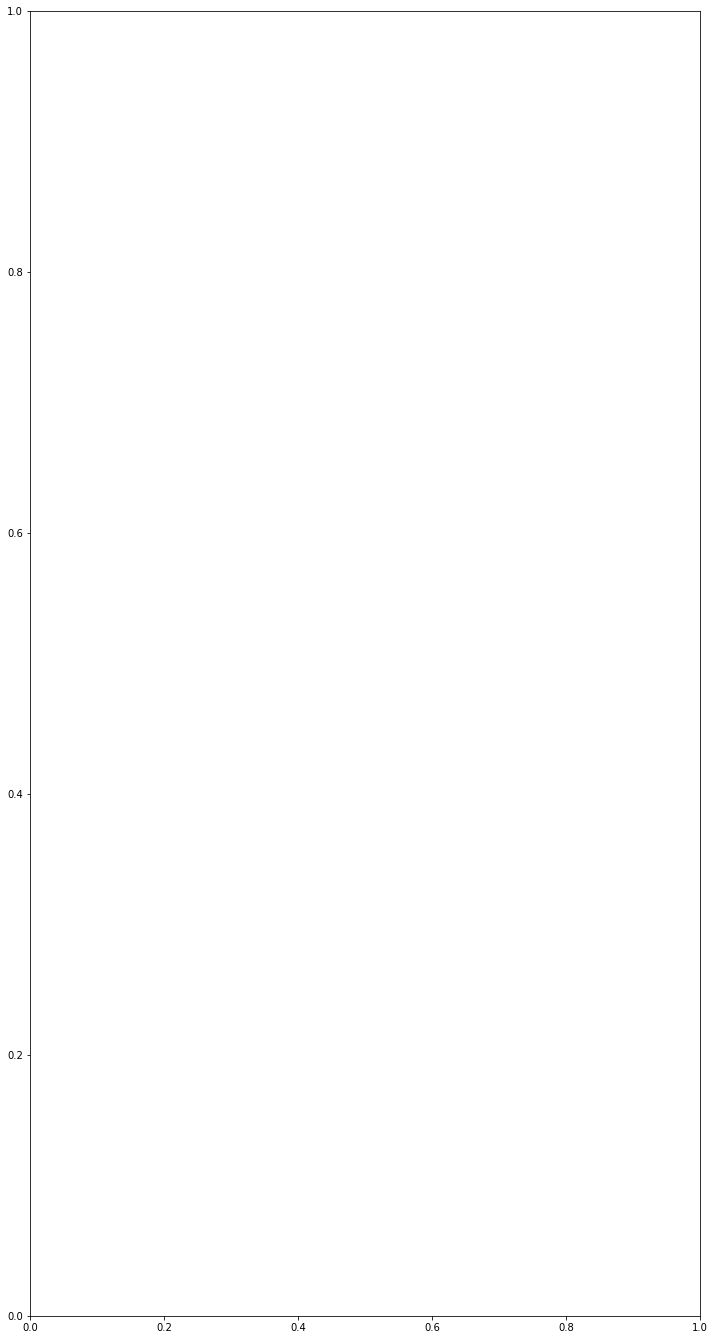

In [100]:
# For simplicity's sake, we'll train a new XGBoost classifier
from xgboost import XGBClassifier
xg = XGBClassifier(max_depth=12, n_estimators=400).fit(x,y)
xg = grid.best_estimator_

fig, ax = plt.subplots(figsize=(12, len(x.columns)//2))

importances = df1(xg.get_fscore,
                        index=x.columns).sort_values(ascending=True)

importances.plot.barh()